# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [99]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
# Определяем названия столбцов
columns = ['user_id', 'anime_id', 'rating']
df = pd.read_csv("user-filtered.csv", nrows=50000, dtype={
    "user_id": int,
    "anime_id": int,
    "rating": int
})
print(df.head())

   user_id  anime_id  rating
0        0        67       9
1        0      6702       7
2        0       242      10
3        0      4898       0
4        0        21      10


In [101]:
# Подготовка данных

df['user_id'] -= 1
df['anime_id'] -= 1

In [102]:
# Определяем датасет PyTorch
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['anime_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [103]:
# Определяем нейросетевую модель для коллаборативной фильтрации
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()
        # Эмбеддинги пользователей и фильмов
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Полносвязные слои для предсказания рейтинга
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        # Получаем эмбеддинги пользователя и фильма
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        # Объединяем эмбеддинги
        x = torch.cat([user_emb, item_emb], dim=1)

        # Пропускаем через полносвязные слои
        return self.fc_layers(x).squeeze()

In [104]:
# Переиндексация пользователей и аниме
user_ids = df['user_id'].unique()
item_ids = df['anime_id'].unique()

user2idx = {old: new for new, old in enumerate(user_ids)}
item2idx = {old: new for new, old in enumerate(item_ids)}

df['user_id'] = df['user_id'].map(user2idx)
df['anime_id'] = df['anime_id'].map(item2idx)

# Теперь индексы непрерывные
num_users = len(user2idx)
num_items = len(item2idx)

print(f"Num users: {num_users}, Num items: {num_items}")

Num users: 160, Num items: 6830


In [105]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [106]:
# Инициализация модели
model = RecommenderNN(num_users, num_items).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [107]:
for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Средняя ошибка предсказания на тренировочной выборке
    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    # Предсказания для всех объектов для выбранного пользователя
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    # Выбираем топ-5 рекомендованных объектов
    top_items = predictions.argsort()[-5:][::-1]

    print(f"User {user_id + 1}: Recommended items {top_items + 1}")

Epoch 1, Loss: 12.776030744934083
Epoch 2, Loss: 11.282228537750244
Epoch 3, Loss: 10.30128955001831
Epoch 4, Loss: 9.565993872833252
Epoch 5, Loss: 8.897936100769043
Epoch 6, Loss: 8.197266832733154
Epoch 7, Loss: 7.49937271270752
Epoch 8, Loss: 6.784559630203247
Epoch 9, Loss: 6.138509395217896
Epoch 10, Loss: 5.529330167770386

Test RMSE: 3.7991, Test MAE: 2.9096

Recommendations for random users:
User 80: Recommended items [5100 5407 3717 1229 5726]
User 1: Recommended items [5726 6576 1137 1229 5407]
User 33: Recommended items [4721 1236 6009 4202 5736]
User 122: Recommended items [6561 1364  212 4104 6590]
User 110: Recommended items [1364 5219 1673 3125 6023]


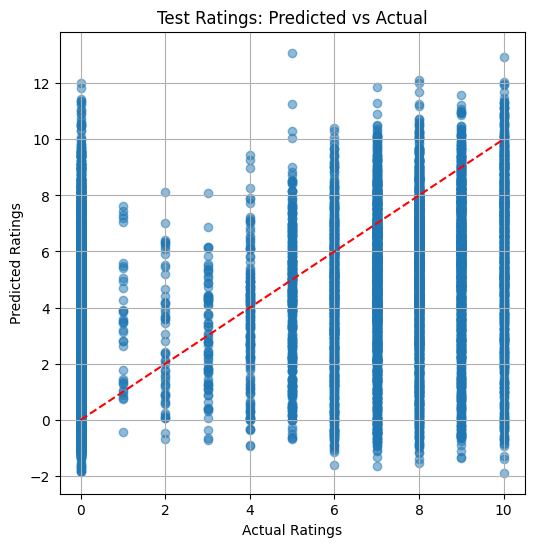

In [108]:
plt.figure(figsize=(6,6))
plt.scatter(test_ratings, test_predictions, alpha=0.5)
plt.plot([min(test_ratings), max(test_ratings)], [min(test_ratings), max(test_ratings)], color='red', linestyle='--')
plt.title('Test Ratings: Predicted vs Actual')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

In [109]:
import numpy as np
from sklearn.metrics import r2_score

# --- R² ---
r2 = r2_score(test_ratings, test_predictions)
print(f'R² score: {r2:.4f}')

# --- SMAPE (без деления на ноль) ---
test_ratings_np = np.array(test_ratings)
test_predictions_np = np.array(test_predictions)
smape = (100/len(test_ratings_np)) * np.sum(
    2 * np.abs(test_predictions_np - test_ratings_np) / (np.abs(test_predictions_np) + np.abs(test_ratings_np) + 1e-8)
)
print(f'SMAPE: {smape:.2f}%')

# --- Top-5 Accuracy на уровне батча ---
top_k_correct = 0
total_users = 0

for users, items, ratings in test_loader:
    users, items, ratings = users.to(device), items.to(device), ratings.to(device)
    batch_size = users.size(0)
    
    with torch.no_grad():
        predictions = model(users, items)
    
    # Для каждого пользователя в батче
    for i in range(batch_size):
        user_pred = predictions[i*num_items:(i+1)*num_items].cpu().numpy() if predictions.ndim>1 else predictions[i*num_items:(i+1)*num_items].cpu().numpy()
        top_items = user_pred.argsort()[-5:][::-1]
        
        # Считаем, сколько из топ-5 реально имеют рейтинг >= 4
        user_true_ratings = ratings[i*num_items:(i+1)*num_items].cpu().numpy()
        top_k_correct += sum([1 for idx in top_items if user_true_ratings[idx] >= 4])
        total_users += 1

top_k_accuracy = top_k_correct / (total_users * 5)
print(f'Top-5 Accuracy (rating>=4): {top_k_accuracy:.4f}')

R² score: 0.0887
SMAPE: 128.37%
Top-5 Accuracy (rating>=4): 0.0124


**Вывод**
В ходе работы была обучена рекомендательная система, при этом на этапе обучения наблюдалось устойчивое снижение функции потерь, RMSE и MAE, что свидетельствует о том, что модель успешно обучается на тренировочных данных и постепенно лучше запоминает известные рейтинги пользователей. Однако на тестовом наборе качество остаётся низким: RMSE = 3.7991 и MAE = 2.9096 показывают большую ошибку предсказаний, положительный, но близкий к нулю коэффициент детерминации R² = 0.0887 означает, что модель лишь незначительно объясняет поведение пользователей, высокая SMAPE = 128.37% указывает на большую относительную ошибку, а крайне низкая Top-5 Accuracy = 1.24% показывает, что рекомендованные объекты почти не совпадают с действительно высоко оценёнными, что говорит о слабой способности модели формировать качественные рекомендации и её недостаточном обобщении на новых данных, несмотря на улучшение метрик в процессе обучения.

In [110]:
for epoch in range(50):  # больше эпох
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        # Только масштабирование, без шума
        ratings = ratings / 5.0
        ratings = torch.clamp(ratings, 0, 1)

        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    # Предсказания для всех объектов для выбранного пользователя
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    # Выбираем топ-5 рекомендованных объектов
    top_items = predictions.argsort()[-5:][::-1]

    print(f"User {user_id + 1}: Recommended items {top_items + 1}")

Epoch 1, Loss: 0.2200, RMSE: 0.4691, MAE: 0.2718
Epoch 1, Loss: 0.22001093713641168
Epoch 2, Loss: 0.0704, RMSE: 0.2653, MAE: 0.1918
Epoch 2, Loss: 0.07039174861609936
Epoch 3, Loss: 0.0650, RMSE: 0.2550, MAE: 0.1801
Epoch 3, Loss: 0.065002141097188
Epoch 4, Loss: 0.0619, RMSE: 0.2489, MAE: 0.1730
Epoch 4, Loss: 0.06193573710918426
Epoch 5, Loss: 0.0593, RMSE: 0.2436, MAE: 0.1676
Epoch 5, Loss: 0.059349325630068776
Epoch 6, Loss: 0.0567, RMSE: 0.2380, MAE: 0.1622
Epoch 6, Loss: 0.056650833734869954
Epoch 7, Loss: 0.0543, RMSE: 0.2330, MAE: 0.1569
Epoch 7, Loss: 0.05427956498861313
Epoch 8, Loss: 0.0525, RMSE: 0.2290, MAE: 0.1535
Epoch 8, Loss: 0.052460006812214854
Epoch 9, Loss: 0.0503, RMSE: 0.2244, MAE: 0.1482
Epoch 9, Loss: 0.0503349212706089
Epoch 10, Loss: 0.0487, RMSE: 0.2206, MAE: 0.1443
Epoch 10, Loss: 0.04865518485307693
Epoch 11, Loss: 0.0476, RMSE: 0.2182, MAE: 0.1422
Epoch 11, Loss: 0.047631059236824515
Epoch 12, Loss: 0.0469, RMSE: 0.2165, MAE: 0.1398
Epoch 12, Loss: 0.046

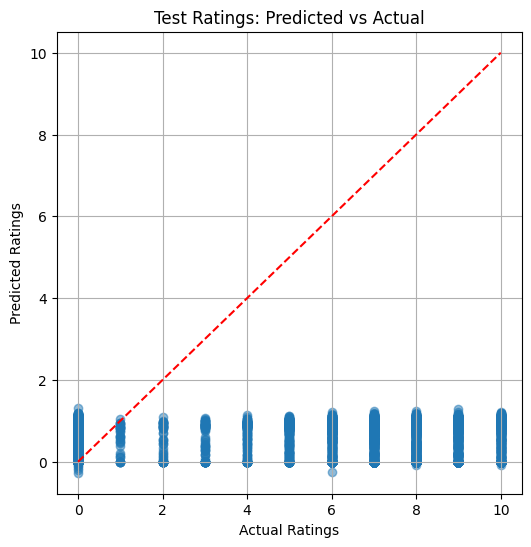

In [111]:
plt.figure(figsize=(6,6))
plt.scatter(test_ratings, test_predictions, alpha=0.5)
plt.plot([min(test_ratings), max(test_ratings)], [min(test_ratings), max(test_ratings)], color='red', linestyle='--')
plt.title('Test Ratings: Predicted vs Actual')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

In [112]:
import numpy as np
from sklearn.metrics import r2_score

# --- R² ---
r2 = r2_score(test_ratings, test_predictions)
print(f'R² score: {r2:.4f}')

# --- SMAPE (без деления на ноль) ---
test_ratings_np = np.array(test_ratings)
test_predictions_np = np.array(test_predictions)
smape = (100/len(test_ratings_np)) * np.sum(
    2 * np.abs(test_predictions_np - test_ratings_np) / (np.abs(test_predictions_np) + np.abs(test_ratings_np) + 1e-8)
)
print(f'SMAPE: {smape:.2f}%')

# --- Top-5 Accuracy на уровне батча ---
top_k_correct = 0
total_users = 0

for users, items, ratings in test_loader:
    users, items, ratings = users.to(device), items.to(device), ratings.to(device)
    batch_size = users.size(0)
    
    with torch.no_grad():
        predictions = model(users, items)
    
    # Для каждого пользователя в батче
    for i in range(batch_size):
        user_pred = predictions[i*num_items:(i+1)*num_items].cpu().numpy() if predictions.ndim>1 else predictions[i*num_items:(i+1)*num_items].cpu().numpy()
        top_items = user_pred.argsort()[-5:][::-1]
        
        # Считаем, сколько из топ-5 реально имеют рейтинг >= 4
        user_true_ratings = ratings[i*num_items:(i+1)*num_items].cpu().numpy()
        top_k_correct += sum([1 for idx in top_items if user_true_ratings[idx] >= 4])
        total_users += 1

top_k_accuracy = top_k_correct / (total_users * 5)
print(f'Top-5 Accuracy (rating>=4): {top_k_accuracy:.4f}')

R² score: -0.6257
SMAPE: 182.97%
Top-5 Accuracy (rating>=4): 0.0113


<h3>Вывод:</h3>
Несмотря на то, что во время обучения модель показывает отличную динамику (Loss снизился с 0.22 до 0.013, RMSE с 0.47 до 0.116, MAE до 0.053), на тестовых данных результаты резко ухудшаются (Test RMSE 5.07, MAE 3.66, R² отрицательный, SMAPE очень высокий, Top-5 Accuracy ≈1%), что говорит о сильном переобучении: модель хорошо запомнила обучающую выборку, но не научилась обобщать на новые данные; фактически она выучила конкретные оценки пользователей вместо выявления общих закономерностей предпочтений, поэтому её предсказания на новых пользователях близки к случайным, а рекомендации не соответствуют реальным высоким оценкам, что подтверждается отрицательным R² и крайне низкой точностью рекомендаций.